<a href="https://colab.research.google.com/github/Fordalo/Data_SCIENCE_WORK/blob/main/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**SARIMA MODEL**

We will now consider seasonailty with our model
SARIMA = AR(p) + MA(q) + differencing + **Seasonality**

$SARIMA(p,d,q)(P,D,Q)_{m}$

*   upper case = seasonal portion
*   lower case = non seasonal portion
*   m = number of observations per year or period. For quarterly, m = 4



________________________________________________________________________
________________________________________________________________________
________________________________________________________________________
________________________________________________________________________





Here are some examples of Basic SARIMA models that can give us insight on how data is processed:

$SARIMA(0,0,0)(0,0,1)_{12}$ 
This is a SARIMA model with a Moving Average of order 1 with monthly periods(12). 



*   ACF spike at lag 12
*   exponential decay in the season lags (12, 24, 36)



$SARIMA(0,0,0)(1,0,0)_{12}$ 
This is a SARIMA model with a Auto Regression of order 1 with monthly periods(12)

*   ACF exponential decay in the season lags (12, 24, 36)
*   PACF spike at lag 12



In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

#for progression bars
from tqdm import tqdm_notebook
from itertools import product
from google.colab import drive
warnings.filterwarnings('ignore')
drive.mount('/content/gdrive')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7.5)

Mounted at /content/gdrive


In [35]:
JJdata = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science projects/Applied Time Series/Moving Average/jj.csv')
JJdata.head(10)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
5,1961-04-02,0.69
6,1961-07-02,0.92
7,1961-10-01,0.55
8,1962-01-01,0.72
9,1962-04-02,0.77


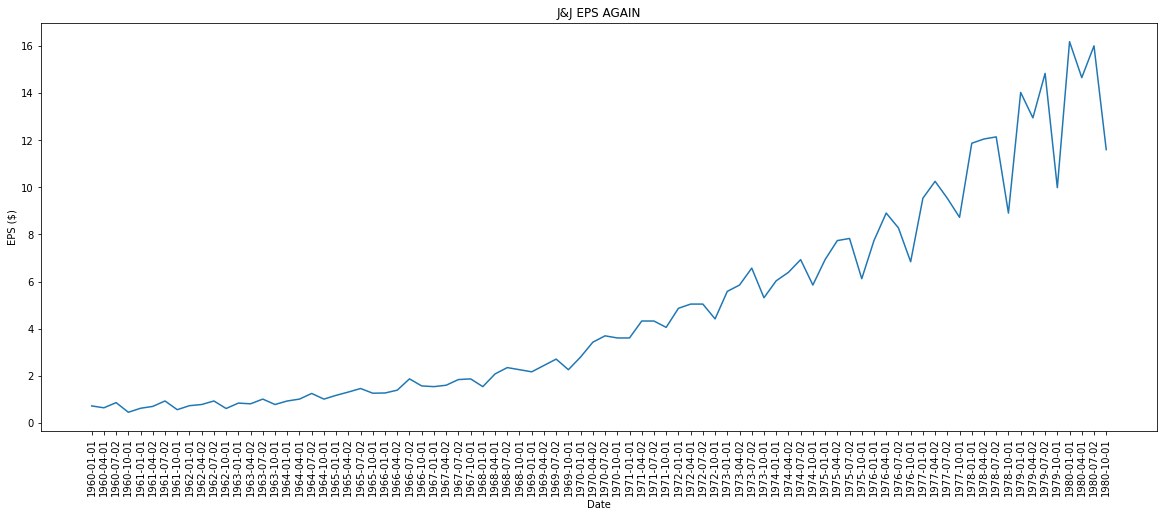

In [36]:
plt.figure(figsize=(20, 7.5))
plt.plot(JJdata['date'], JJdata['data'])
plt.title('J&J EPS AGAIN')
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('EPS ($)')
plt.show()

<Figure size 360x270 with 0 Axes>

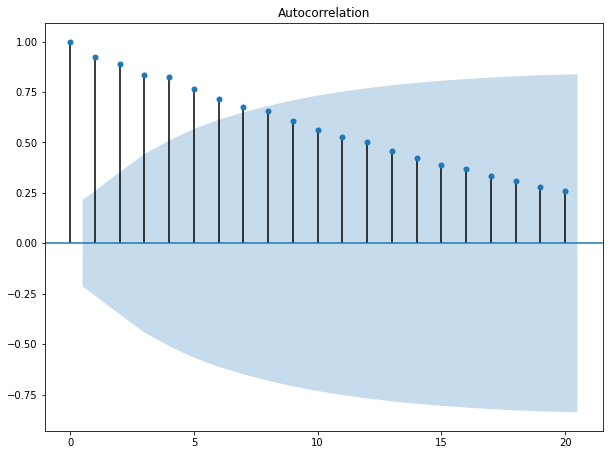

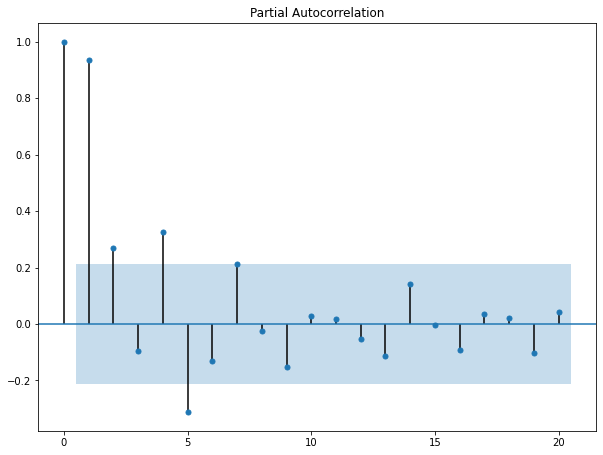

In [37]:
#stationarity check
plt.figure(figsize=(5, 3.75))
plot_acf(JJdata['data']);
plot_pacf(JJdata['data']);

In [38]:
#data will not be stationary, pvalue will be too high
adfullerresult = adfuller(JJdata['data'])
print(f'statistic: {adfullerresult[0]} \nPvalue: {adfullerresult[1]}')

statistic: 2.742016573457476 
Pvalue: 1.0


In [39]:
#applying transformation to make data stationary

JJdata['moded'] = np.log(JJdata['data'])
JJdata['moded'] = JJdata['moded'].diff()
JJdata.head(10)

,date,data,moded
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


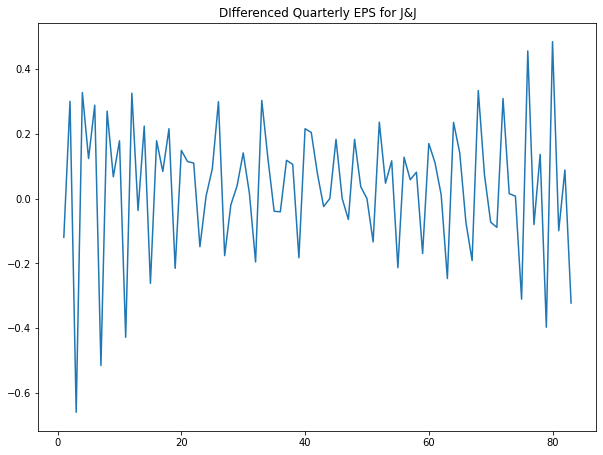

In [40]:
plt.plot(JJdata['moded'][1:])
plt.title('DIfferenced Quarterly EPS for J&J')
plt.show()

In [41]:
adfuller_res2 = adfuller(JJdata['moded'][1:])
print(f'statistic: {adfuller_res2[0]} \nPvalue: {adfuller_res2[1]}')

statistic: -4.317043945811839 
Pvalue: 0.000414973140444062


We know that the data is stationary, but there is still alot of variance. Variance is higher at the ends, and less in the model. We will make a second transformation

In [42]:
#we are dealing with QUARTERLY data so the diff order is 4
#we do a seasonal differencing
# we loose 4 more points in our dataset equating to 5
JJdata['moded2'] = JJdata['moded'][1:].diff(4)
JJdata.head(10)

,date,data,moded,moded2
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.119545,NaN
2,1960-07-02,0.85,0.299517,NaN
3,1960-10-01,0.44,-0.658462,NaN
4,1961-01-01,0.61,0.326684,NaN
5,1961-04-02,0.69,0.123233,0.242778
6,1961-07-02,0.92,0.287682,-0.011834
7,1961-10-01,0.55,-0.514455,0.144006
8,1962-01-01,0.72,0.269333,-0.057351
9,1962-04-02,0.77,0.067139,-0.056093


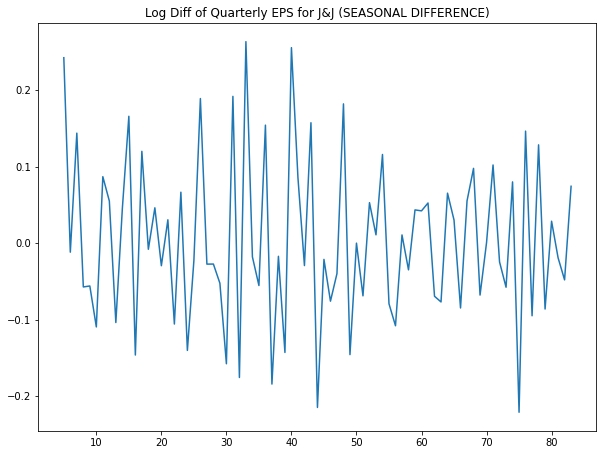

In [43]:
#This should reduce variance
plt.plot(JJdata['moded2'])
plt.title('Log Diff of Quarterly EPS for J&J (SEASONAL DIFFERENCE)')
plt.show()

In [44]:
adfuller_res3 = adfuller(JJdata['moded2'][5:])
print(f'statistic: {adfuller_res3[0]} \nPvalue: {adfuller_res3[1]}')

statistic: -6.630805109914263 
Pvalue: 5.72157869513621e-09


<Figure size 360x270 with 0 Axes>

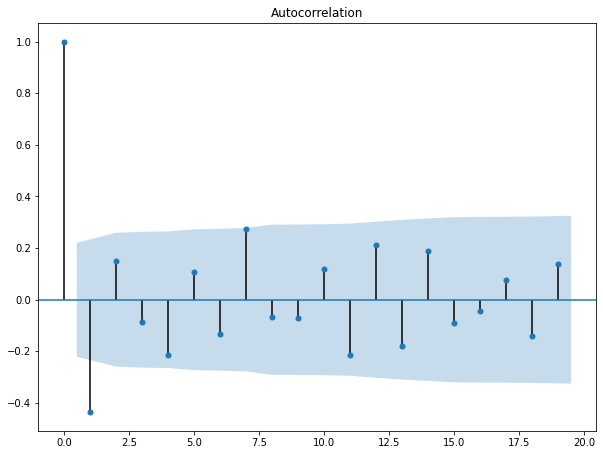

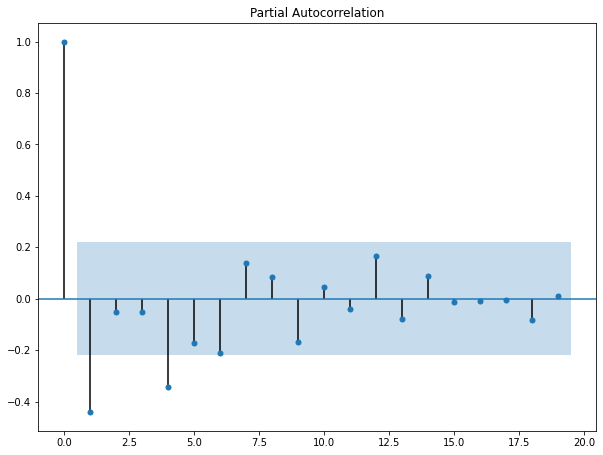

In [45]:
#stationarity check
plt.figure(figsize=(5, 3.75))
plot_acf(JJdata['moded2'][5:]);
plot_pacf(JJdata['moded2'][5:]);

In [49]:
#Lets optomize our model to find the right parameters with a custom function

def optomize_SARIMA(data, param_list, d, D, s):
  """
    Will return dataframe with list of paramters and corresponding AIC
    Param_list = list of (p,q,P,Q) tuples
    d = integration order
    D = seasonal integration order
    s = length of season

  """

  #storing results in a list
  results = []

  for param in tqdm_notebook(param_list):
    try:
      model = SARIMAX(data, order=(param[0], d, param[1]), seasonal_order= (param[2], D, param[3], s), simple_differencing= False).fit(disp= False)
    except:
      continue
    
    aic = model.aic
    results.append([param, aic])

  results_df = pd.DataFrame(results)
  results_df.columns = ['(p,q) & (P,Q)', 'AIC']


  results_df = results_df.sort_values(by= 'AIC', ascending = True).reset_index(drop = True)
  return results_df

#Creating our param list
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)

parameters = product(p,q,P,Q)
param_list_test = list(parameters)
print(len(param_list_test))
print(param_list_test[0:20])
  

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3), (0, 0, 3, 0), (0, 0, 3, 1), (0, 0, 3, 2), (0, 0, 3, 3), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 0, 3)]


In [50]:

JJ_SARIMA_DF = optomize_SARIMA(JJdata['data'], param_list_test, 1, 1, 4)

  0%|          | 0/256 [00:00<?, ?it/s]

In [51]:
JJ_SARIMA_DF

,"(p,q) & (P,Q)",AIC
0,"(2, 3, 0, 0)",92.588733
1,"(2, 3, 1, 0)",93.976830
2,"(2, 3, 0, 1)",94.131656
3,"(3, 2, 0, 3)",94.200973
4,"(3, 3, 0, 0)",94.468557
...,...,...
251,"(0, 0, 3, 1)",144.211575
252,"(0, 0, 3, 3)",145.086453
253,"(0, 0, 2, 3)",145.465209
254,"(0, 0, 3, 2)",145.563923


In [54]:
best_model = SARIMAX(JJdata['data'], order = (2,1,3), seasonal_order= (0, 1, 0, 4), simple_differencing= False)
res = best_model.fit(disp = False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                              data   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 4)   Log Likelihood                 -40.294
Date:                           Fri, 12 Aug 2022   AIC                             92.589
Time:                                   17:19:29   BIC                            106.805
Sample:                                        0   HQIC                            98.284
                                            - 84                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4865      0.116    -12.790      0.000      -1.714      -1.259
ar.L2         -0.7924      0.131     -6.035      0.000      -1.050      -0.535
ma.L1          0.7705      0.513      1.501      0.133      -0.236       1.777
ma.L2         -0.1089      0.324     -0.336      0.737      -0.744       0.526
ma.L3         -0.7321      0.464     -1.578      0.115      -1.641       0.177
sigma2         0.1518      0.099      1.532      0.125      -0.042       0.346
===================================================================================
Ljung-Box (Q):                       30.89   Jarque-Bera (JB):                40.36
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              25.99   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

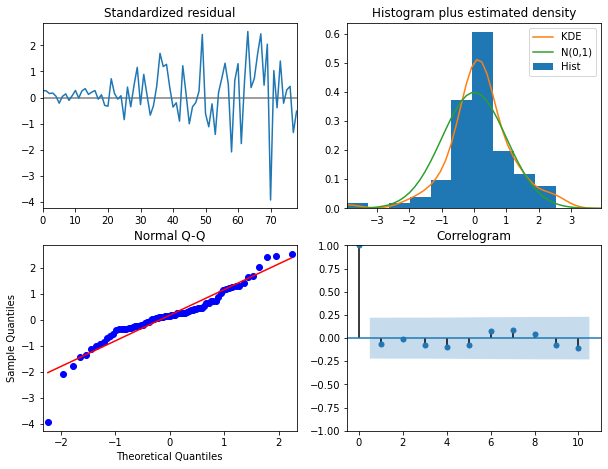

In [56]:
#residuals
#if residuals are normal, we can use the model to make predictions
res.plot_diagnostics();

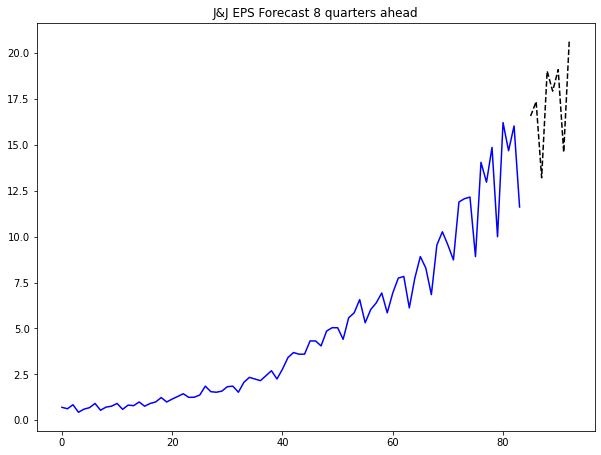

In [57]:
#forcasting 2 years ahead with quarters
steps = 8
predict = res.get_prediction(end = best_model.nobs + steps)
idx = np.arange(len(predict.predicted_mean))
fig, ax = plt.subplots()

ax.plot(JJdata['data'], 'blue')
ax.plot(idx[-steps:], predict.predicted_mean[-steps: ], 'k--' )
ax.set(title = 'J&J EPS Forecast 8 quarters ahead')
plt.show()

In [58]:
JJdata['model'] = predict.predicted_mean
JJdata.head(5)

,date,data,moded,moded2,model
0,1960-01-01,0.71,NaN,NaN,0.000
1,1960-04-01,0.63,-0.119545,NaN,0.710
2,1960-07-02,0.85,0.299517,NaN,0.630
3,1960-10-01,0.44,-0.658462,NaN,0.850
4,1961-01-01,0.61,0.326684,NaN,0.795


In [59]:
mse = mean_squared_error(JJdata['data'], JJdata['model'])
print(mse)

0.15613942412399825


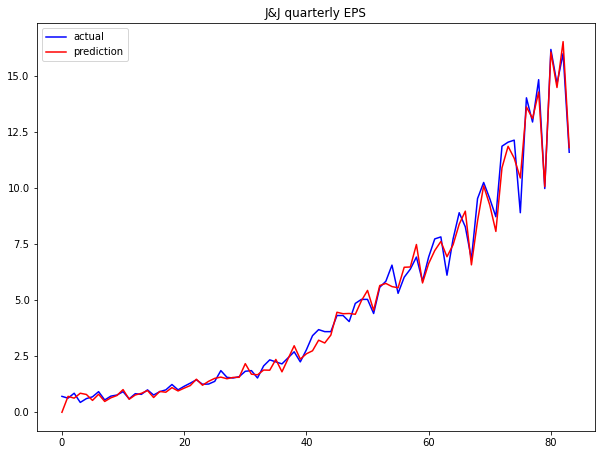

In [60]:
#lets visualize how our model did vs actuals
plt.plot(JJdata['data'], color = 'blue', label = 'actual')
plt.plot(JJdata['model'], color = 'red', label = 'prediction')
plt.legend(loc = 'best')
plt.title('J&J quarterly EPS')
plt.show()